# Importar Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 1. Cargar Arhivos

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
# Usaremos train donde esta la variable objetivo Transported

In [3]:
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)

Train set shape: (8693, 14)
Test set shape: (4277, 13)


In [4]:
train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True



> * **PassengerId** - Una identificación única para cada pasajero. Cada ID toma el formato gggg_pp donde gggg indica un grupo con el que viaja el pasajero y pp es su número dentro del grupo. Las personas de un grupo suelen ser miembros de la familia, pero no siempre.
> * **HomePlanet** - El planeta desde el que partió el pasajero, normalmente su planeta de residencia permanente.
> * **CryoSleep** - Indica si el pasajero eligió permanecer en animación suspendida durante la duración del viaje. Los pasajeros en criosueño están confinados en sus cabinas.
> * **Cabin** - El número de cabina donde se hospeda el pasajero. Toma el formato cubierta/número/lado, donde el lado puede ser P para Babor o S para Estribor.
> * **Destination** - El planeta hacia el que desembarcará el pasajero.
> * **Age** - La edad del pasajero.
> * **VIP** - Si el pasajero ha pagado por un servicio VIP especial durante el viaje.
> * **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Monto que el pasajero ha facturado en cada una de las muchas comodidades de lujo del Spaceship Titanic.
> * **Name** - El nombre y apellido del pasajero.
> * **Transported** - Si el pasajero fue transportado a otra dimensión. Este es el objetivo, la columna que intentas predecir.

#### 1.1 Definir Variable Objetivo

In [5]:
# Guardar PassengerId para submission
test_ids = test["PassengerId"]

# Variable objetivo
y = train["Transported"]
X = train.drop("Transported", axis=1)

In [6]:
print('VALORES FALTANTES TRAIN:')
print(train.isna().sum())
print('')
print('VALORES FALTANTES TEST:')
print(test.isna().sum())

VALORES FALTANTES TRAIN:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

VALORES FALTANTES TEST:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


#### 1.2 Duplicados

In [7]:
print(f'Duplicados en Train: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print('')
print(f'Duplicados en Test: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')

Duplicados en Train: 0, (0.0%)

Duplicados en Test: 0, (0.0%)


In [8]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


#### 1.3 Cardinalidad de características.

In [9]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

*Nota*
* 6 Características continuas.
* 4 Características categóricas (excluyendo el objetivo).
* 3 Características descriptivas/cualitativas.

In [10]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

# 2. Exploratory Data Analysis (EDA)

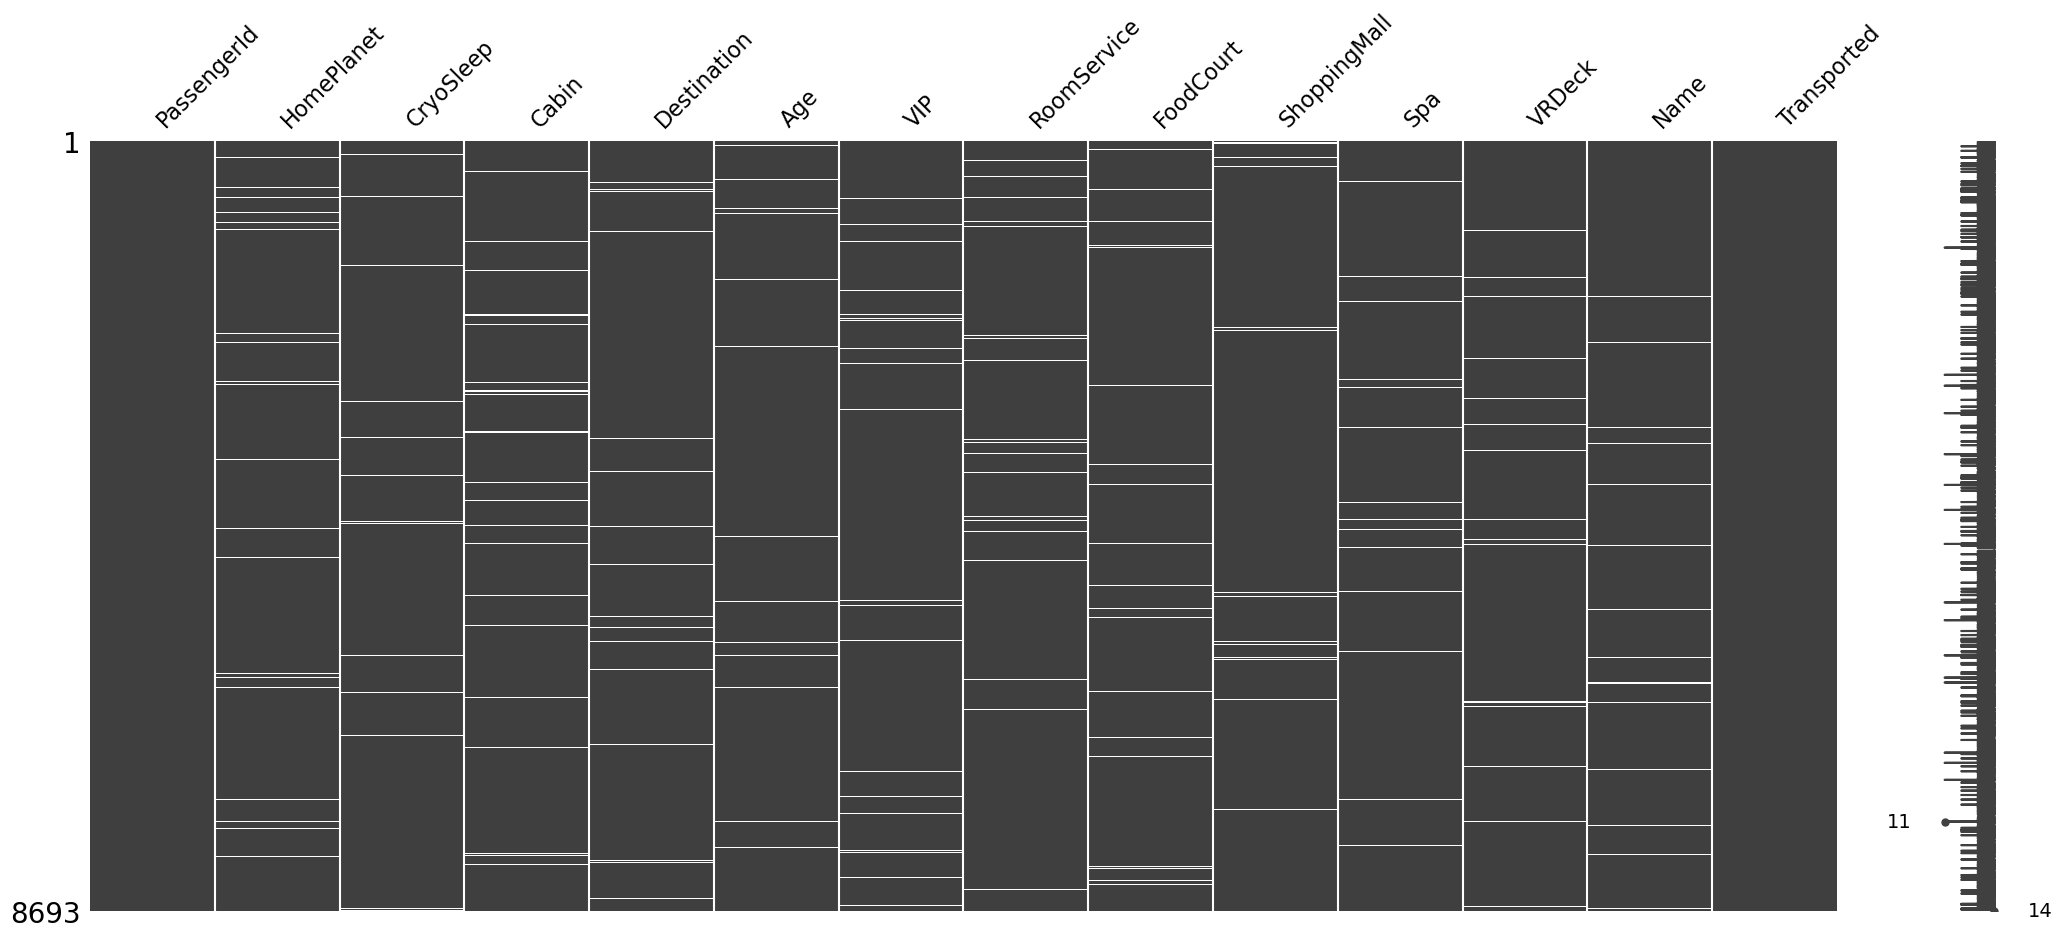

In [11]:
msno.matrix(train)
plt.show()

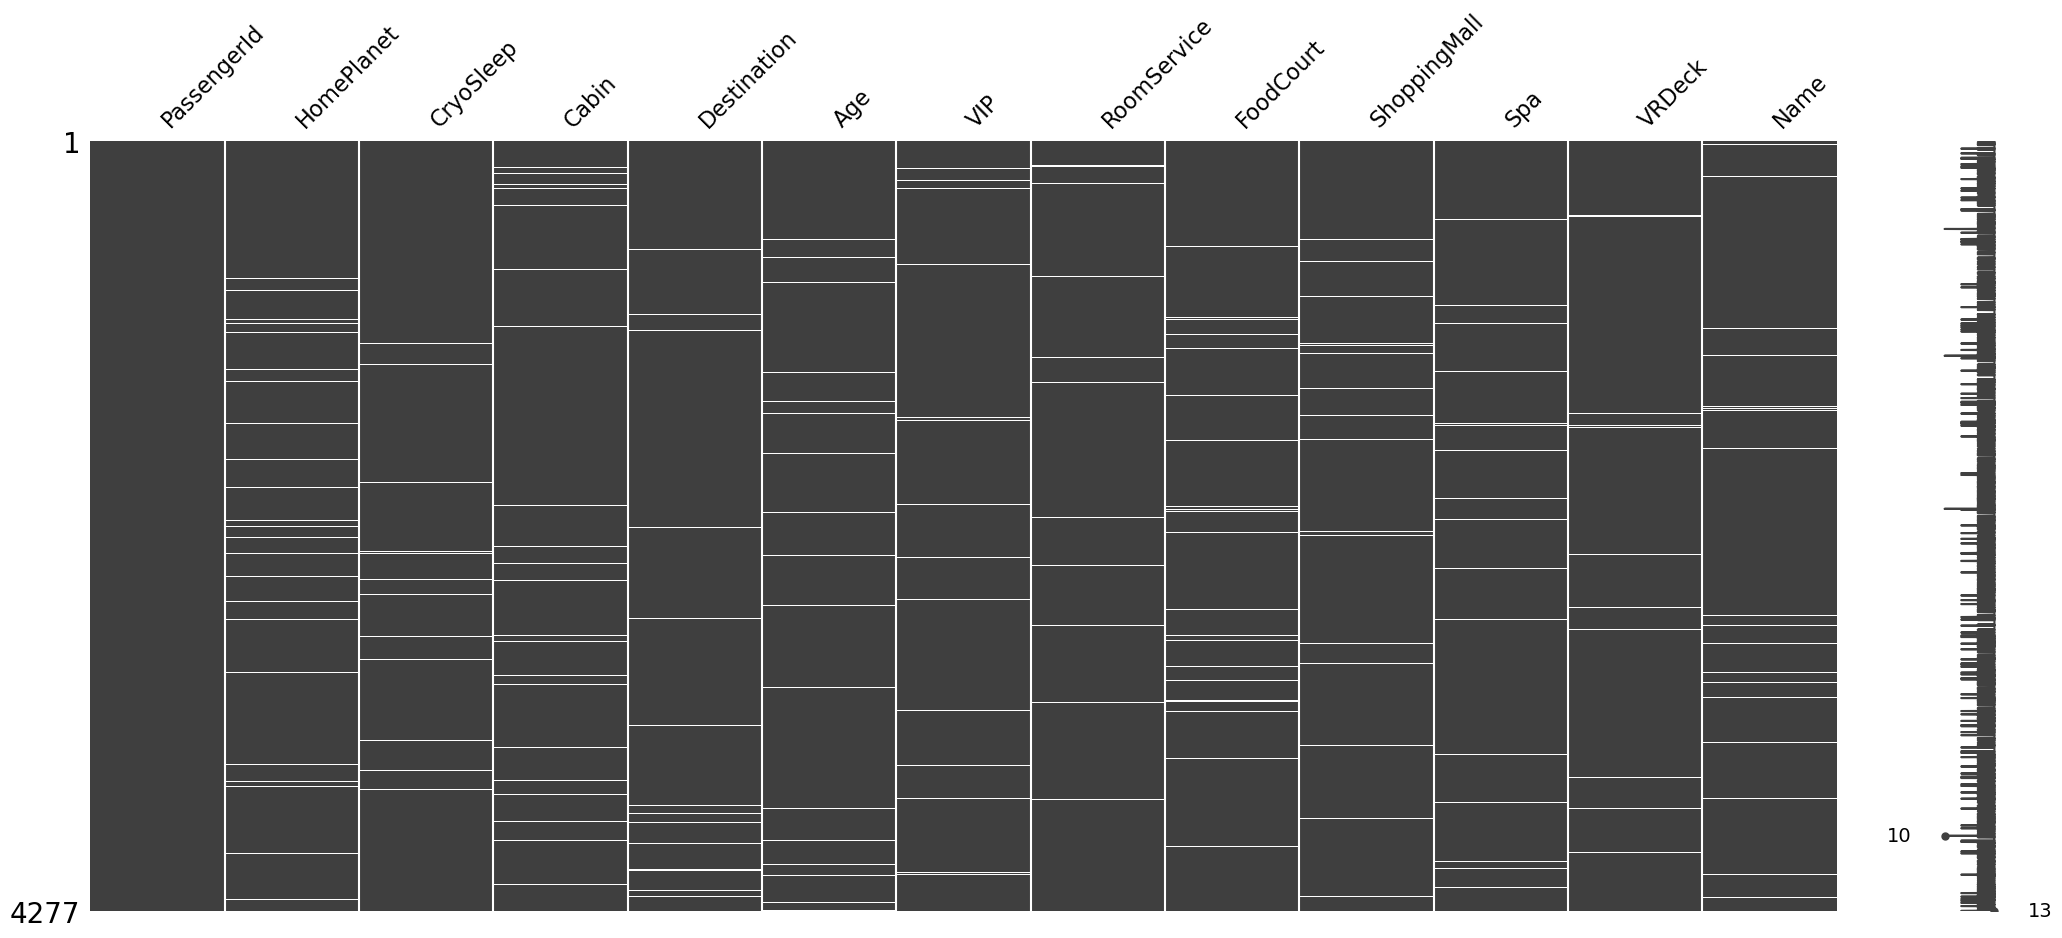

In [12]:
msno.matrix(test)
plt.show()

#### 2.1 Distribucion de Variable Objetivo

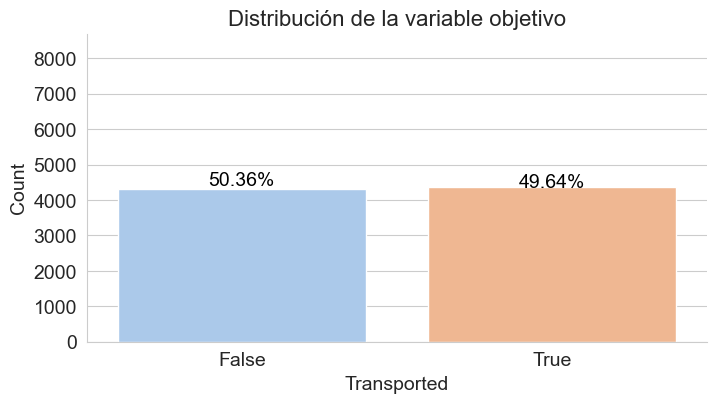

In [13]:
# Calculate the proportion of each class
class_counts = train['Transported'].value_counts()
class_proportions = class_counts / train.shape[0]
class_proportions = class_proportions.values.tolist()
class_proportions_str = [f'{prop:.2%}' for prop in class_proportions]

# Set the color palette
colors = sns.color_palette('pastel')[0:len(class_counts)]

# Plot the distribution of the target variable
sns.set_style("whitegrid")
plt.figure(figsize=(8, 4))
sns.countplot(x='Transported', data=train, hue='Transported', palette=colors, legend=False)
plt.title('Distribución de la variable objetivo', fontsize=16)
plt.xlabel('Transported', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.ylim([0, len(train)])
for i, count in enumerate(class_counts):
    plt.text(i, count + 50, class_proportions_str[i], ha='center', fontsize=14, color='black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine()
plt.show()

El objetivo está muy equilibrado, por lo que afortunadamente no tenemos que considerar técnicas como el submuestreo o el sobremuestreo.

#### 2.2 Visualizacion de Variables

In [14]:
cont_cols=[f for f in train.columns if train[f].dtype in [float,int] and train[f].nunique()>3]

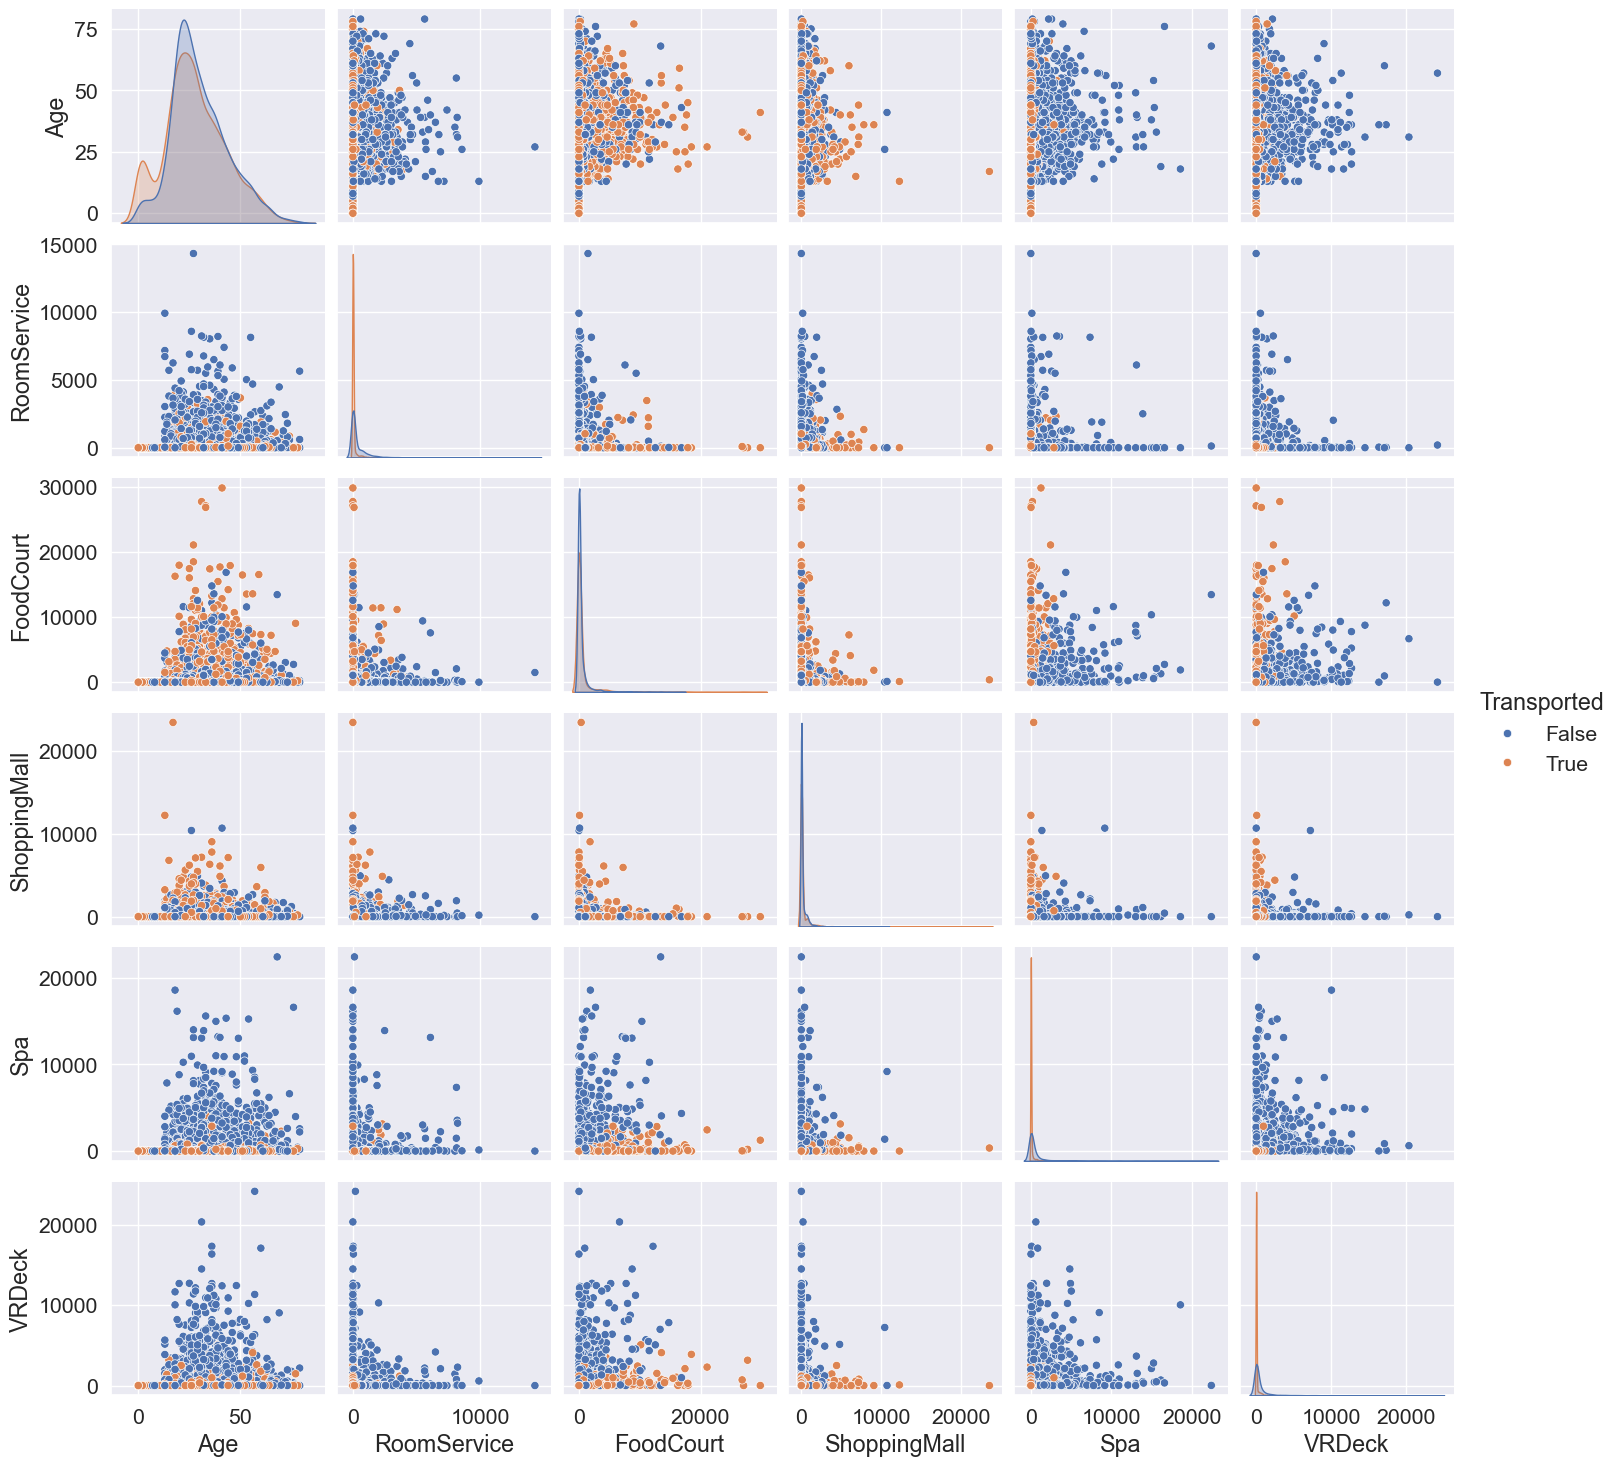

In [15]:
sns.set(style='darkgrid', font_scale=1.4)

sns.pairplot(data=train, vars=cont_cols, hue='Transported')
plt.show()

*Notas*

* Visualizamos que las edades jovenes tienes mas probabilidad de ser trasportados
* Los que no usan RoomService, Spa y VRDeck tienen mas probabilidad de ser trasportados
* FoodCourt y ShopingMall comparten similitudes.

*Perspectiva*

*Analizaremos de cerca estos valores

#### 2. 3 Variables Continuas

Text(0.5, 0, 'Age (years)')

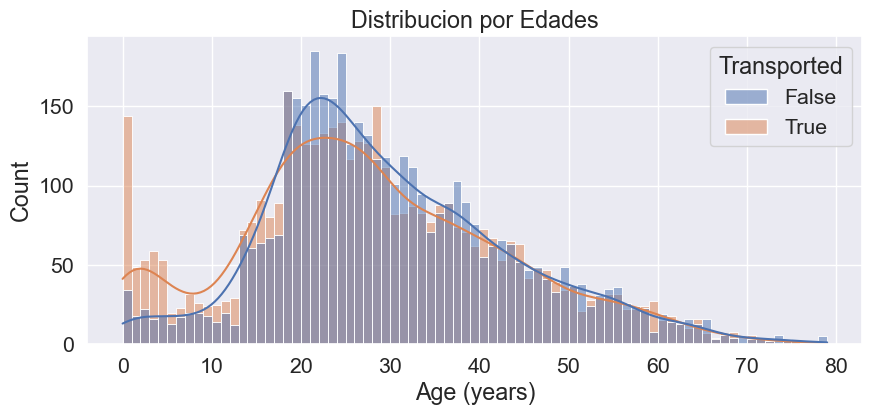

In [16]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True) # kde Estimacion de densidad
plt.title('Distribucion por Edades')
plt.xlabel('Age (years)')

*Notas:*

* Los niños de 0 a 18 años tenían **más** probabilidades de ser transportados que los que no.
* Los jóvenes de 19 a 28 años tenían **menos** probabilidades de ser transportados que los que no.
* Las personas mayores de 28 años tenían la **misma** probabilidad de ser transportadas que de no ser transportadas.

*Perspectiva:*

* Crear una nueva característica que indique si el pasajero es niño, adolescente o adulto.

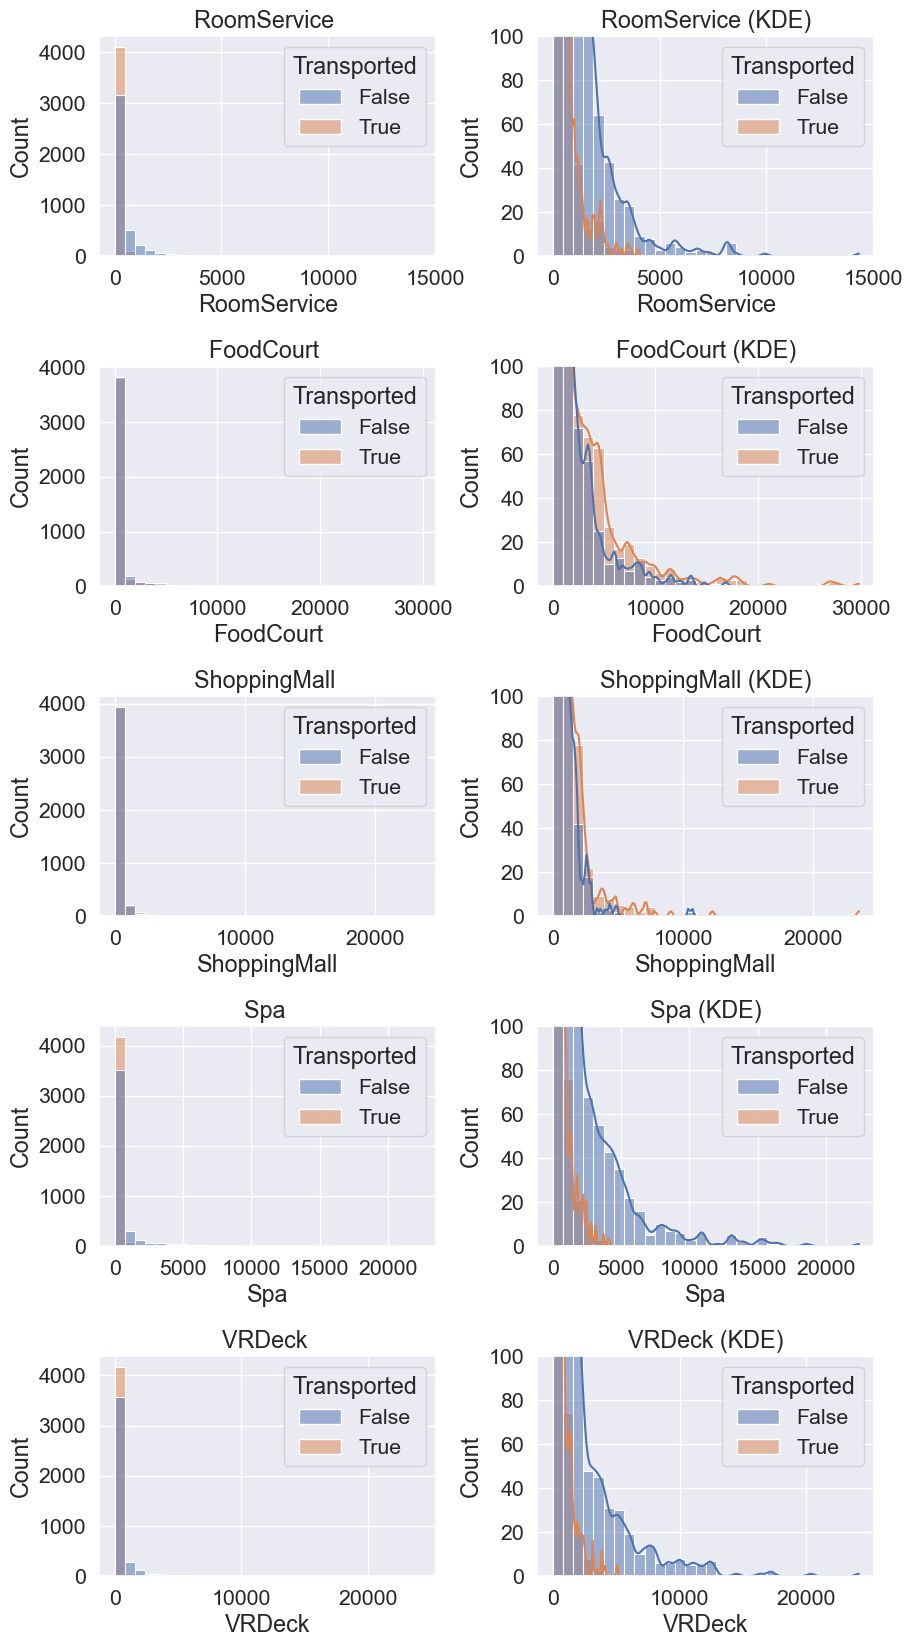

In [17]:
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
fig = plt.figure(figsize=(10, 20))

for i, var in enumerate(exp_feats):
    
    for j, kde_flag in enumerate([False, True]):
        ax = fig.add_subplot(5, 2, 2*i + j + 1)
        sns.histplot(
            data=train,
            x=var,
            bins=30,
            kde=kde_flag,
            hue='Transported',
            ax=ax
        )
        if kde_flag:
            ax.set_ylim(0, 100)
        ax.set_title(f"{var} {'(KDE)' if kde_flag else ''}")
# Ajuste de espacio
plt.subplots_adjust(hspace=0.5, wspace=0.3)

*Notas:*

* La mayoría de la gente no gasta dinero (como podemos ver a la izquierda).
* La distribución del gasto decae exponencialmente (como podemos ver a la derecha).
* Hay una pequeña cantidad de valores atípicos.
* Las personas que fueron transportadas tendieron a gastar menos.
* RoomService, Spa y VRDeck tienen distribuciones diferentes a FoodCourt y ShoppingMall; podemos pensar en esto como lujo versus servicios esenciales.

*Perspectiva:*

* Cree una nueva función que rastree el gasto total en los 5 servicios.
* Crea una función binaria para indicar si la persona no ha gastado nada. (es decir, el gasto total es 0).
* Realice la transformación logarítmica para reducir la inclinación.

#### 2. 4 Variables Categoricas

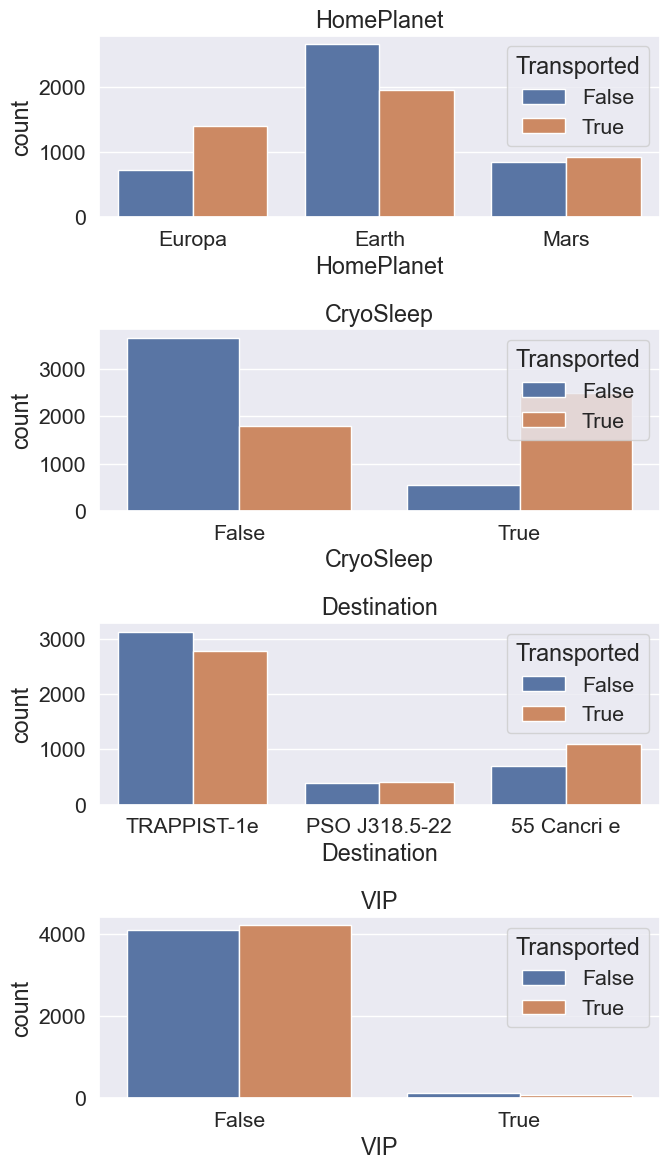

In [18]:
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(7,12))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  
plt.show()

*Notas:*

* VIP no parece ser una característica útil; la división objetivo es más o menos igual.
* Por el contrario, CryoSleep parece ser una característica muy útil.

*Perspectivas:*

* Podríamos considerar eliminar la columna VIP para evitar un ajuste excesivo.

#### 2.5 Variables Cualitativas/Descriptivas

In [19]:
qual_feats=['PassengerId', 'Cabin' ,'Name']

# Preview qualitative features
train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


*Notas:*

* PassengerId toma el formato gggg_pp donde gggg indica un grupo con el que viaja el pasajero y pp es su número dentro del grupo.
* La cabina toma la forma cubierta/número/lado, donde el lado puede ser P para Babor o S para Estribor.

*Perspectivas:*

* Podemos extraer el grupo y el tamaño del grupo de la función PassengerId.
* Podemos extraer la cubierta, el número y el costado de la característica de la cabina.
* Podríamos extraer el apellido de la característica del nombre para identificar familias.

# 3. Ingenieria de Caracteristicas
*Mejores caracteristicas hacen mejores modelos*

#### 3.1 Agrupar Edades

In [20]:
def add_age_group(df, col='Age'):
    bins = [0, 10, 18, 28, 37, 46, 59, np.inf]
    labels = [
        'Age_0-10',
        'Age_11-18',
        'Age_19-28',
        'Age_29-37',
        'Age_38-46',
        'Age_47-59',
        'Age_60+'
    ]
    df['Age_group'] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    return df

train = add_age_group(train)
test = add_age_group(test)

Text(0.5, 1.0, 'Agrupacion por edades')

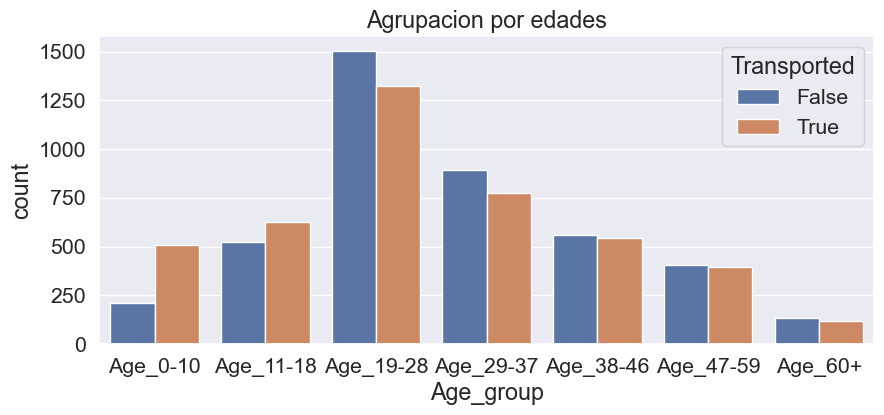

In [21]:
# Plot distribution of new features
plt.figure(figsize=(10,4))
g=sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-10','Age_11-18','Age_19-28','Age_29-37','Age_38-46','Age_47-59','Age_60+'])
plt.title('Agrupacion por edades')

#### 3.2 Gastos

Calcular el gasto total e identifica a los pasajeros sin gasto.

In [22]:
for df in [train, test]:
    df['Expenditure'] = df[exp_feats].sum(axis=1) # Gasto total
    df['No_spending'] = (df['Expenditure'] == 0).astype(int) # Sin_Gastos

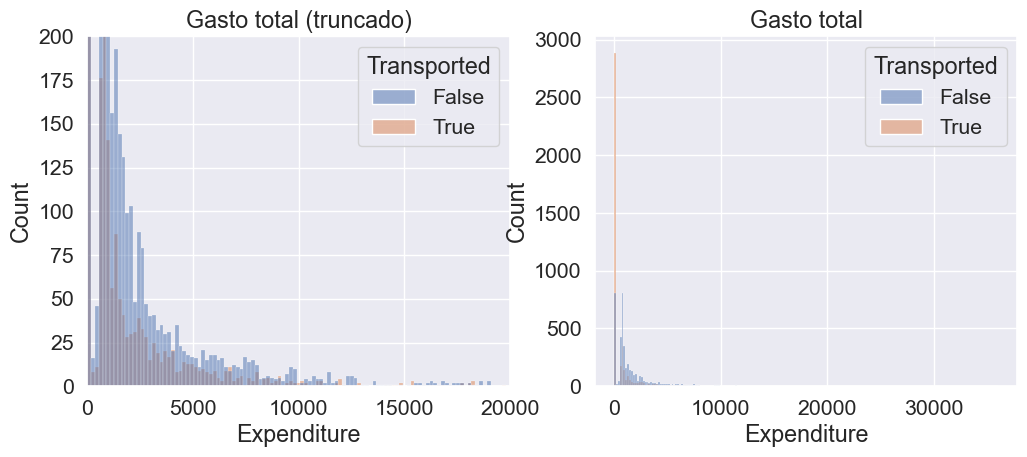

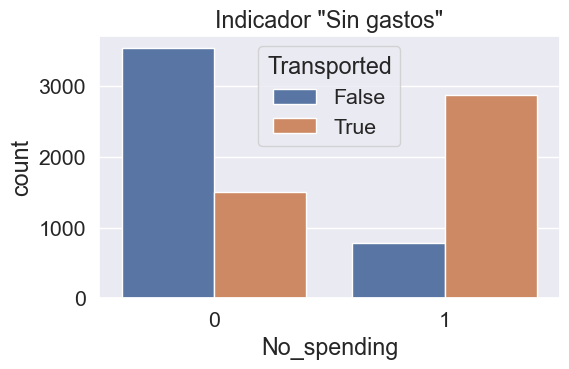

In [23]:
# Graficamos las nuevas distribuciones
fig=plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Gasto total (truncado)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(2,2,2)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Gasto total')

fig=plt.figure(figsize=(6,4))
sns.countplot(data=train, x='No_spending', hue='Transported')
plt.title('Indicador "Sin gastos"')
fig.tight_layout()

*Nota*
* Podemos ver que los que no gastaron tuvieron mas posibilidades de ser trasnportados.
* Al contrario los que realizaron algun gasto tenian menos posibilidades de ser transportados.
* Entendemos que al no haber gastado es porque seguramente se encontraban en CryoSleep.

#### 3.3 Agrupacion de pasajeros

Estraemos el grupo de pasajeros y el tamaño del grupo de PassengerId.

In [24]:
# Extraer Group desde PassengerId
for df in [train, test]:
    df['Group'] = df['PassengerId'].str.split('_').str[0].astype(int)

# Calcular tamaño del grupo usando train + test
group_counts = pd.concat([train['Group'], test['Group']]).value_counts()

for df in [train, test]:
    df['Group_size'] = df['Group'].map(group_counts)
    df['Is_alone'] = (df['Group_size'] == 1).astype(int)

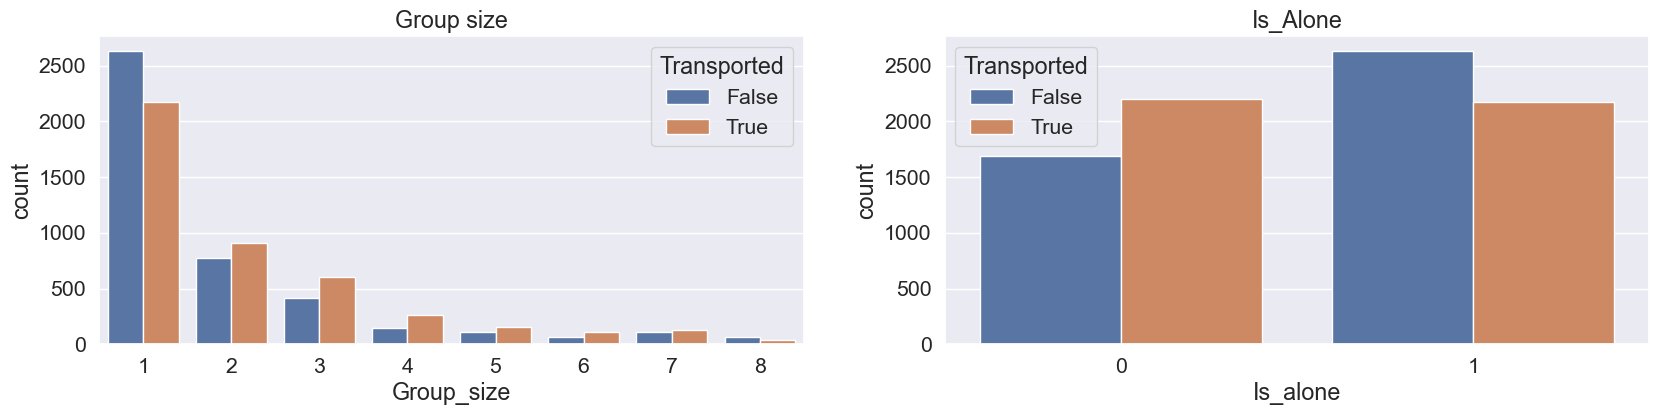

In [25]:
# Plot distribution of new features
plt.figure(figsize=(20,4))
#plt.subplot(1,2,1)
#sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
#plt.title('Group')

plt.subplot(1,2,1)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

plt.subplot(1,2,2)
sns.countplot(data=train, x='Is_alone', hue='Transported')
plt.title('Is_Alone')
fig.tight_layout()

Realmente no podemos usar la función Grupo en nuestros modelos porque tiene una cardinalidad demasiado grande y explotaría el número de dimensiones con codificación one-hot.

Por otro lado, el tamaño del grupo debería ser una característica útil. De hecho, podemos comprimir aún más la función creando una columna 'Is_alone' que rastrea si alguien viaja solo o no. La figura de la derecha muestra que es menos probable que un grupo de tamaño = 1 sea transportado que un grupo de tamaño > 1.

#### 3.4 Ubicación de la cabina

Estraeremos cubierta/número/lado(P-S) de la columna cabina.

In [26]:
for df in [train, test]:
    cabin_split = df['Cabin'].str.split('/', expand=True)

    df['Cabin_deck'] = cabin_split[0]
    df['Cabin_number'] = pd.to_numeric(cabin_split[1], errors='coerce')
    df['Cabin_side'] = cabin_split[2]

    df['Cabin_known'] = df['Cabin_number'].notna().astype(int)

    df.drop(columns='Cabin', inplace=True)

In [27]:
cols = ['Cabin_deck', 'Cabin_number', 'Cabin_side', 'Cabin_known']
for col in cols:
    print(f'\nDistribución de {col}:')
    print(train[col].value_counts(dropna=False))


Distribución de Cabin_deck:
Cabin_deck
F      2794
G      2559
E       876
B       779
C       747
D       478
A       256
NaN     199
T         5
Name: count, dtype: int64

Distribución de Cabin_number:
Cabin_number
NaN       199
82.0       28
86.0       22
19.0       22
56.0       21
         ... 
1644.0      1
1515.0      1
1639.0      1
1277.0      1
1894.0      1
Name: count, Length: 1818, dtype: int64

Distribución de Cabin_side:
Cabin_side
S      4288
P      4206
NaN     199
Name: count, dtype: int64

Distribución de Cabin_known:
Cabin_known
1    8494
0     199
Name: count, dtype: int64


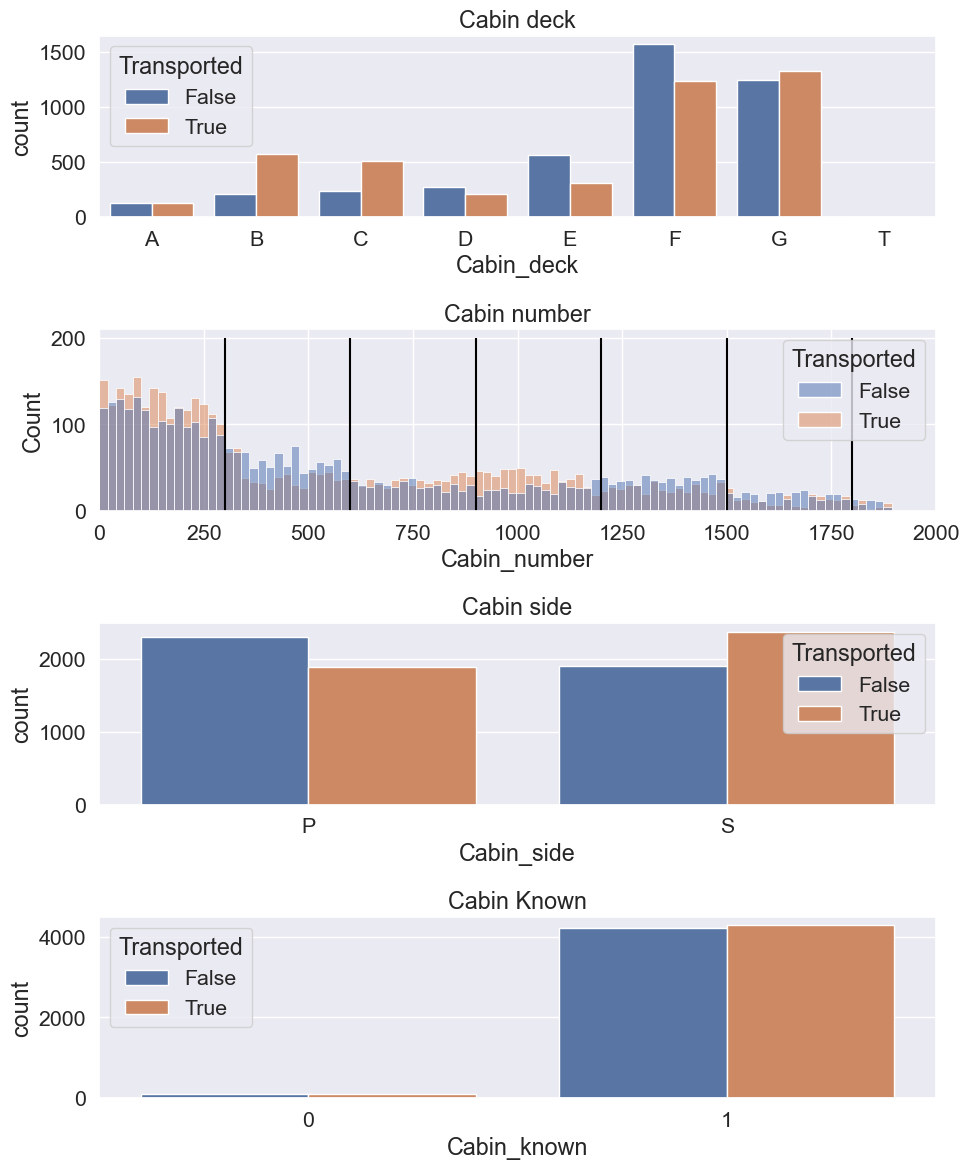

In [28]:
# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(4,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(4,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(4,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

plt.subplot(4,1,4)
sns.countplot(data=train, x='Cabin_known', hue='Transported')
plt.title('Cabin Known')
fig.tight_layout()

plt.show()

Observaremos que tan predictivas es estas variable:

In [29]:
train.groupby('Transported')['Cabin_known'].mean()

Transported
False    0.977057
True     0.977159
Name: Cabin_known, dtype: float64

*Notas*
Encontramos muchos datos interesantes.

* En 'Cabin_Deck' tenemos en 'T' solo 5 muestras, parece ser un caso atipico.
* Observamos en 'Cabin_Deck' que en B y C es mas probable sen trasnportado a diferencia de F y E.
* Parece que 'Cabin_number' esta agrupado en grupos de 300 cabañas.
* Podemos comprimir esta característica en una categórica, que indica en qué segmento se encuentra cada pasajero.
* Tiene 1818 valores unicos, con mucha dispersion y ninguna secuencia aparente.
* En 'Cabin_side' observamos que en S(Estribor) es mas probable ser trasportado que en P(Babor).
* 'Cabin_Known' nos da una buena reproducibilidad, coincide con los 199 valores faltantes de las demas columnas.
* Por el contrario tiene una diferencia ≈ 0.0001 → estadísticamente irrelevante con 'Transported', podriamos eliminarla sin problema.


#### 3.5 Apellido

Calcule el tamaño de la familia a partir del apellido.

In [30]:
# Combinar para conteos globales
full = pd.concat([train[['Name']], test[['Name']]])

# Extraer apellido (Surname)
full['Surname'] = full['Name'].str.split().str[-1]

# Calcular tamaño de familia
surname_counts = full['Surname'].value_counts()

# Aplicar a train y test
for df in [train, test]:
    df['Surname'] = df['Name'].str.split().str[-1]
    df['Family_size'] = df['Surname'].map(surname_counts)

    # Manejar Unknown
    df.loc[df['Surname'].isna(), 'Family_size'] = 0

    df.drop(columns='Name', inplace=True)

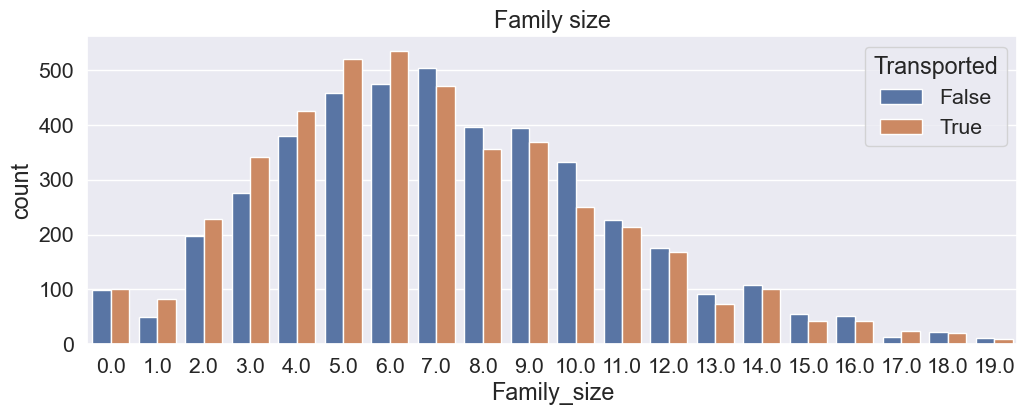

In [31]:
plt.figure(figsize=(12,4))
sns.countplot(data=train,x='Family_size', hue='Transported')
plt.title('Family size')
#plt.xlim(0, 10)
plt.show()


In [32]:
for df in [train, test]:
    df['Is_family'] = (df['Family_size'] > 1).astype(int)

In [33]:
print(train.groupby('Transported')['Family_size'].mean())
print(train.groupby('Transported')['Is_family'].mean())

Transported
False    7.253998
True     6.872088
Name: Family_size, dtype: float64
Transported
False    0.965469
True     0.957972
Name: Is_family, dtype: float64


In [34]:
for df in [train, test]:
    df.drop(columns='Is_family', inplace=True)

*Notas*

* Borramos Is_Family no aporta señal real.

# 4. Valores faltantes

#### 4.1 Combina entrenar y probar

Esto hará que sea más fácil completar los valores faltantes. Lo dividiremos más tarde.

In [35]:
# Labels and features
y=train['Transported'].copy().astype(int)
X=train.drop('Transported', axis=1).copy()

# Concatenate dataframes
data=pd.concat([X, test], axis=0).reset_index(drop=True)

#### 4.2 Explorar valores faltantes

In [36]:
# Columnas con valores faltantes
na_cols=data.columns[data.isna().any()].tolist()

# Resumen de valores faltantes
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Numeros_Faltantes'])
mv['Porcentaje']=np.round(100*mv['Numeros_Faltantes']/len(data),2)
print(mv)

              Numeros_Faltantes  Porcentaje
HomePlanet                  288        2.22
CryoSleep                   310        2.39
Destination                 274        2.11
Age                         270        2.08
VIP                         296        2.28
RoomService                 263        2.03
FoodCourt                   289        2.23
ShoppingMall                306        2.36
Spa                         284        2.19
VRDeck                      268        2.07
Age_group                   270        2.08
Cabin_deck                  299        2.31
Cabin_number                299        2.31
Cabin_side                  299        2.31
Surname                     294        2.27


Text(0.5, 1.0, 'Mapa de calor de valores perdidos')

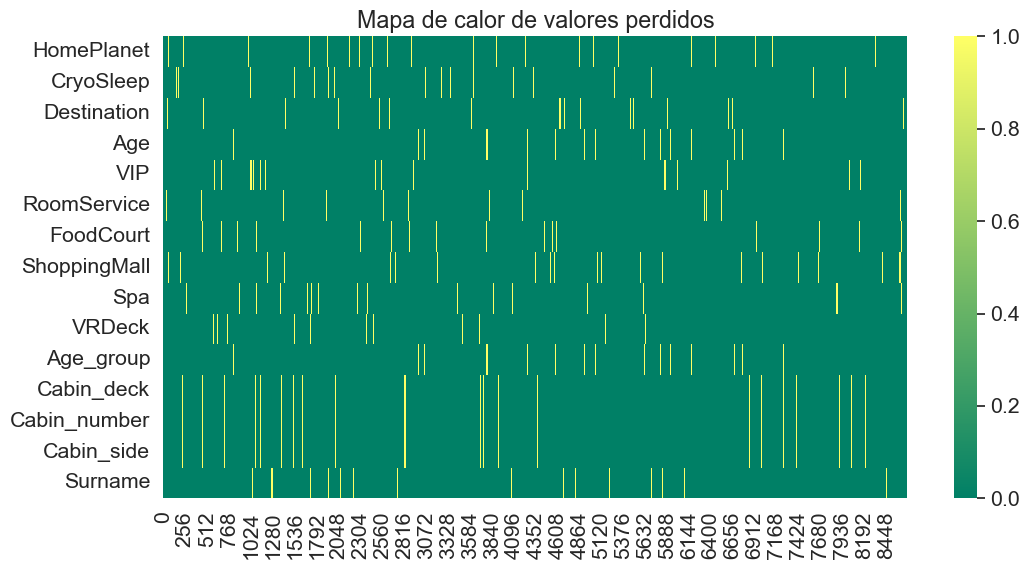

In [37]:
plt.figure(figsize=(12,6))
sns.heatmap(train[na_cols].isna().T, cmap='summer')
plt.title('Mapa de calor de valores perdidos')

Los valores faltantes representan aproximadamente el 2% de los datos, que es una cantidad relativamente pequeña.  
En su mayor parte, no parecen estar sucediendo al mismo tiempo (excepto las funciones creadas al dividir Cabina y Nombre), pero inspeccionemos más de cerca.

Notas:

Los valores faltantes son independientes del objetivo y en su mayor parte están aislados.
Aunque solo falta el 2% de los datos, a alrededor del 25% de todos los pasajeros les falta al menos 1 valor.
PassengerId es la única característica (original) a la que no le faltan valores.
Perspectiva:

Dado que la mayoría de los valores faltantes están aislados, tiene sentido intentar completarlos en lugar de simplemente eliminar filas.
Si existe una relación entre PassengerId y otras características, podemos completar los valores faltantes de acuerdo con esta columna.

Estrategia

La forma más fácil de lidiar con los valores faltantes es simplemente usar la mediana para características continuas y la moda para características categóricas (consulte la versión 20 de este cuaderno). Esto funcionará "bastante bien", pero si queremos maximizar la precisión de nuestros modelos, entonces debemos buscar patrones dentro de los datos faltantes. La forma de hacerlo es observando la distribución conjunta de características, p. ¿Los pasajeros de un mismo grupo suelen proceder de la misma familia? Obviamente hay muchas combinaciones, por lo que simplemente resumiremos las tendencias útiles que yo y otros hemos encontrado.

In [38]:
# Variables Categoricas
cat_cols = ['HomePlanet', 'Destination', 'Cabin_deck', 'Cabin_side']
bin_cols = ['CryoSleep', 'VIP']
num_zero_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for df in [train, test]:
    df[cat_cols] = df[cat_cols].fillna('Unknown')
    df[bin_cols] = df[bin_cols].fillna(df[bin_cols].mode().iloc[0])
    df[num_zero_cols] = df[num_zero_cols].fillna(0)
    df['Age'] = df['Age'].fillna(df['Age'].median())


C:\Users\raicl\AppData\Local\Temp\ipykernel_9072\2807491957.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bin_cols] = df[bin_cols].fillna(df[bin_cols].mode().iloc[0])
C:\Users\raicl\AppData\Local\Temp\ipykernel_9072\2807491957.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bin_cols] = df[bin_cols].fillna(df[bin_cols].mode().iloc[0])


In [39]:
# Importante volver recrear los valores depues de imputar
train = add_age_group(train)
test = add_age_group(test)

In [40]:
drop_cols = ['Cabin_number', 'Surname']
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

In [41]:
assert train.isna().sum().sum() == 0
assert test.isna().sum().sum() == 0

In [42]:
train.isna().sum().sort_values(ascending=False)


PassengerId     0
HomePlanet      0
Cabin_known     0
Cabin_side      0
Cabin_deck      0
Is_alone        0
Group_size      0
Group           0
No_spending     0
Expenditure     0
Age_group       0
Transported     0
VRDeck          0
Spa             0
ShoppingMall    0
FoodCourt       0
RoomService     0
VIP             0
Age             0
Destination     0
CryoSleep       0
Family_size     0
dtype: int64

# 5. Preprocesamiento
#### 5.1 Agrupar por tipos de variables

In [43]:
y = train['Transported'].astype(int)
features = train.drop(columns='Transported').columns.tolist()
num_cols = train[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = train[features].select_dtypes(include=['object', 'category']).columns.tolist()
bin_cols = train[features].select_dtypes(include=['bool']).columns.tolist()

Realizamos la Transformada Logaritmica para las variables numericas en especial en los gastos, ya que en un principio parecian muy sesgadas, pero la prediccion del modelo disminuyo en un %2 por lo que al finla no lo utilizamos

#### 5.2 Transformacion Logartimica y Preprocesamiento
La transformada logarítmica se utiliza para disminuir la asimetría en las distribuciones, especialmente con valores atípicos grandes. Puede facilitar que los algoritmos "aprendan" las relaciones correctas. Lo aplicaremos a las características del gasto, ya que están muy sesgadas por valores atípicos.

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('bin', 'passthrough', bin_cols)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [45]:
# Entrenar el modelo
X = train.drop(columns='Transported')
model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'Expenditure', 'Group_size',
                                                   'Family_size']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['PassengerId', 'HomePlanet',
                                                   'Destination', 'Age_group',
                                                   'Cabin_deck',
                                                   'Cabin_side']),
                                                 ('bin', 'passthrough',
                                                  ['CryoSleep', 'VIP'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

#### 5.3 Validación cruzada.
Evaluar qué tan bien generaliza el modelo.

In [46]:
# Como Transported es binaria → StratifiedKFold:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
print(f'Accuracy CV: {scores.mean():.4f} ± {scores.std():.4f}')

Accuracy CV: 0.7940 ± 0.0053


#### 5.4 Predicciones

In [47]:
model.fit(X, y)
y_pred = model.predict(X)

In [48]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4315
           1       0.87      0.88      0.88      4378

    accuracy                           0.87      8693
   macro avg       0.87      0.87      0.87      8693
weighted avg       0.87      0.87      0.87      8693



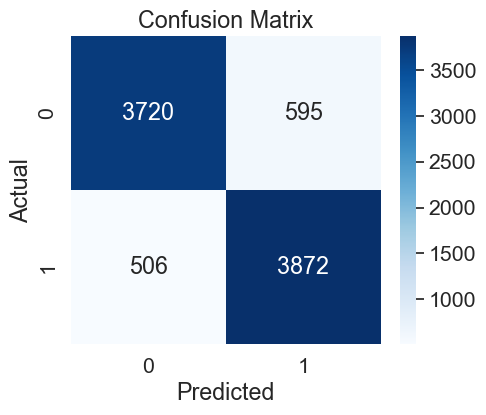

In [49]:
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### 5.5 Feature Importance (interpretación/Visualizacion)

In [50]:
# Accediendo al One-Hot
preprocessor = model.named_steps['preprocessor']
feature_names = model.named_steps['preprocessor'].get_feature_names_out()


# Analizar coeficientes
coef = model.named_steps['classifier'].coef_[0]

importance = pd.DataFrame({
    'feature': feature_names,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

In [51]:
print(len(feature_names))
print(len(coef))

8731
8731


In [52]:
'''
importance['feature'] = importance['feature'].str.replace('cat__', '')
importance['feature'] = importance['feature'].str.replace('num__', '')
importance['feature'] = importance['feature'].str.replace('bin__', '')

'''

"\nimportance['feature'] = importance['feature'].str.replace('cat__', '')\nimportance['feature'] = importance['feature'].str.replace('num__', '')\nimportance['feature'] = importance['feature'].str.replace('bin__', '')\n\n"

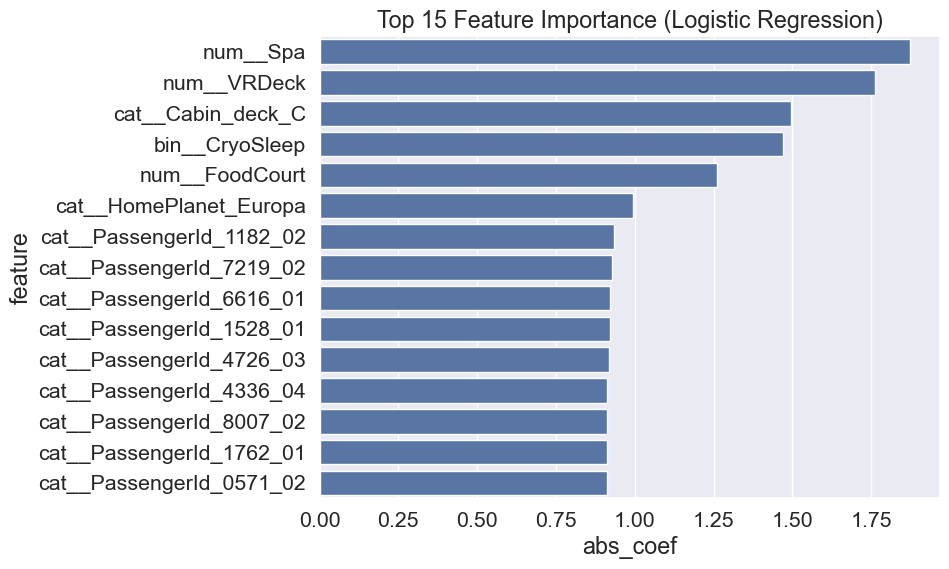

In [53]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=importance.head(15),
    x='abs_coef',
    y='feature'
)
plt.title('Top 15 Feature Importance (Logistic Regression)')
plt.show()

# 6. Evaluacion de Modelos
#### 6.1 RandomForest

In [54]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # mismo que Logistic
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ))
])

In [55]:
#Validacion Cruzada
rf_scores = cross_val_score(
    rf_model, X, y,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print(f'RandomForest: {rf_scores.mean():.4f}')

RandomForest: 0.7880


#### 6.2 XGBost

In [56]:
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

In [57]:
#Validacion Cruzada
xgb_scores = cross_val_score(
    xgb_model, X, y,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print(f'XGBoost: {xgb_scores.mean():.4f}')

XGBoost: 0.8006


#### 6.3 CatBost

In [58]:
# Columnas categoricas sin One-Hot
cat_features_idx = [X.columns.get_loc(col) for col in cat_cols]

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=False
)

In [59]:
cv_scores = []

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    cat_model.fit(
        X_train, y_train,
        cat_features=cat_features_idx
    )

    preds = cat_model.predict(X_val)
    cv_scores.append((preds == y_val).mean())

print(f'CatBoost: {np.mean(cv_scores):.4f}')

CatBoost: 0.8146


In [60]:
results = pd.DataFrame({
    'Model': ['Logistic', 'RandomForest', 'XGBoost', 'CatBoost'],
    'CV_Accuracy': [
        scores.mean(),
        rf_scores.mean(),
        xgb_scores.mean(),
        np.mean(cv_scores)
    ]
})

results.sort_values('CV_Accuracy', ascending=False)

,Model,CV_Accuracy
3,CatBoost,0.814565
2,XGBoost,0.800643
0,Logistic,0.793972
1,RandomForest,0.787990


In [61]:
'''
rf_model.fit(X, y)
importances = rf_model.named_steps['classifier'].feature_importances_
'''

"\nrf_model.fit(X, y)\nimportances = rf_model.named_steps['classifier'].feature_importances_\n"

In [62]:
cat_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Group,11.877194
1,Cabin_deck,9.156968
2,HomePlanet,8.403349
3,Spa,8.358723
4,VRDeck,7.824143
5,Expenditure,7.040133
6,FoodCourt,6.839159
7,Cabin_side,6.729958
8,RoomService,5.210251
9,ShoppingMall,4.930151


In [63]:
feat_imp = cat_model.get_feature_importance(prettified=True)

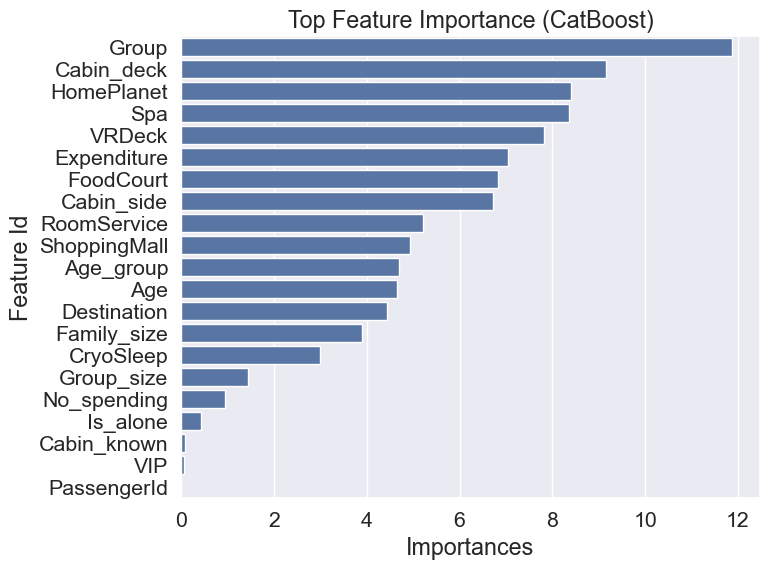

In [65]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=feat_imp.head(21),
    x='Importances',
    y='Feature Id'
)
plt.title(f'Top Feature Importance (CatBoost)')
plt.tight_layout()
plt.show()

*Nota*

* Estas son las variables con mas peso

# 7. Crear el hold-out final 

In [67]:
# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### 7.1 Entrenar CatBoost en el hold-out

Índices de columnas categóricas.
CatBoost necesita índices, no nombres:


In [68]:
cat_features_idx = [X.columns.get_loc(col) for col in cat_cols]

#### 7.2 Modelo Final

In [69]:
final_cat_model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.03,
    depth=8,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100
)

In [70]:
# Entrenamiento con validacion
final_cat_model.fit(X_train, y_train, cat_features=cat_features_idx, eval_set=(X_val, y_val), use_best_model=True)

0:	learn: 0.7598504	test: 0.7527315	best: 0.7527315 (0)	total: 53ms	remaining: 42.4s
100:	learn: 0.8193845	test: 0.7952846	best: 0.7975848 (90)	total: 3.65s	remaining: 25.3s
200:	learn: 0.8402358	test: 0.8033353	best: 0.8033353 (198)	total: 7.27s	remaining: 21.7s
300:	learn: 0.8572045	test: 0.8079356	best: 0.8090857 (296)	total: 10.9s	remaining: 18.1s
400:	learn: 0.8737417	test: 0.8079356	best: 0.8102358 (393)	total: 15.7s	remaining: 15.6s
500:	learn: 0.8889848	test: 0.8102358	best: 0.8131110 (437)	total: 19.7s	remaining: 11.7s
600:	learn: 0.9052344	test: 0.8119609	best: 0.8131110 (437)	total: 23.6s	remaining: 7.82s
700:	learn: 0.9188956	test: 0.8119609	best: 0.8142611 (622)	total: 27.7s	remaining: 3.91s
799:	learn: 0.9285303	test: 0.8096607	best: 0.8142611 (622)	total: 32s	remaining: 0us

bestTest = 0.8142610696
bestIteration = 622

Shrink model to first 623 iterations.


#### 7.3 Evaluacion final

In [71]:

y_val_pred = final_cat_model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Accuracy: 0.8142610695802185
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       863
           1       0.82      0.81      0.82       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



El accuracy es parecido al CV (~0.81–0.83) → modelo sano

#### 7.4 Matriz de confusion

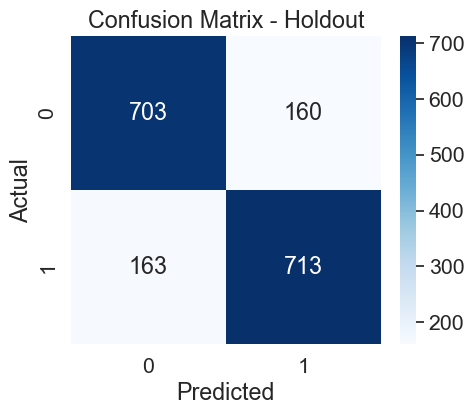

In [72]:
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Holdout')
plt.show()

#### 7.5 Entrenar con TODO el train (modelo final)

Después del hold-out, reentrenamos usando todos los datos:

In [73]:
final_cat_model.fit(
    X, y,
    cat_features=cat_features_idx,
    verbose=100
)

0:	learn: 0.7371448	total: 30.7ms	remaining: 24.5s
100:	learn: 0.8206603	total: 3.99s	remaining: 27.6s
200:	learn: 0.8383757	total: 7.63s	remaining: 22.8s
300:	learn: 0.8509145	total: 11.3s	remaining: 18.8s
400:	learn: 0.8692051	total: 15.2s	remaining: 15.1s
500:	learn: 0.8826642	total: 19.1s	remaining: 11.4s
600:	learn: 0.8938226	total: 23.6s	remaining: 7.82s
700:	learn: 0.9047509	total: 27.7s	remaining: 3.91s
799:	learn: 0.9124583	total: 31.9s	remaining: 0us


#### 7.6 Crear predccion en el test

In [74]:
test_preds = final_cat_model.predict(test)

In [75]:
test_preds = test_preds.astype(bool)

# 8. Crear submission

In [76]:
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': test_preds
})

In [77]:
print(submission.head())
print(submission.shape)
submission['Transported'].value_counts(normalize=True)

  PassengerId  Transported
0     0013_01        False
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True
(4277, 2)


Transported
False    0.509703
True     0.490297
Name: proportion, dtype: float64

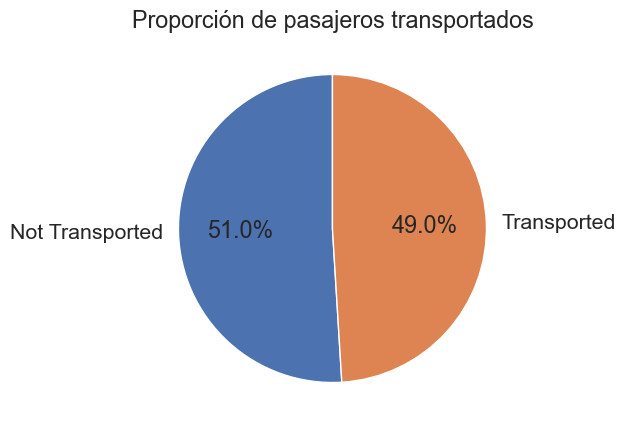

In [78]:
counts = submission['Transported'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(
    counts,
    labels=counts.index.map({True: 'Transported', False: 'Not Transported'}),
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Proporción de pasajeros transportados')
plt.show()

In [79]:
# Guardar archivo
submission.to_csv('submission.csv', index=False)